In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
from sklearn.metrics import precision_score

# Define calculation functions for each indicator

def calculate_ema(data, period):
    ema = data["Close"].ewm(span=period, min_periods=period).mean()
    return ema

def calculate_bollinger_bands(data, window):
    std = data["Close"].ewm(span=window, min_periods=window).std()
    upper_band = data["Close"] + 2 * std
    lower_band = data["Close"] - 2 * std
    return upper_band, lower_band

def calculate_rsi(data, period):
    delta = data["Close"].diff(1)
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    up_ema = up.ewm(span=period, min_periods=period).mean()
    down_ema = down.ewm(span=period, min_periods=period).mean()
    rsi = 100 - 100 / (1 + up_ema / down_ema)
    return rsi

def calculate_stochastic_oscillator(data, k, d):
    lowest_low = data["Low"].rolling(window=k).min()
    highest_high = data["High"].rolling(window=k).max()
    k_value = 100 * (data["Close"] - lowest_low) / (highest_high - lowest_low)
    d_value = k_value.ewm(span=d, min_periods=d).mean()
    return k_value, d_value

def calculate_obv(data):
    obv = data["Close"].diff() * data["Volume"]
    obv = obv.cumsum()
    return obv

def calculate_cmf(data):
    cmf = (data["Close"] - data["Low"]) - (data["High"] - data["Close"]) / (data["Volume"] * (data["High"] - data["Low"]))
    return cmf

def calculate_atr(data, period):
    true_range = pd.concat([data["High"] - data["Low"],
                            abs(data["High"] - data["Close"].shift(1)),
                            abs(data["Low"] - data["Close"].shift(1))], axis=1).max(axis=1)
    atr = true_range.ewm(span=period, min_periods=period).mean()
    return atr

# Fetch historical stock data using Yahoo Finance
def fetch_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data["EMA"] = calculate_ema(data.copy(), 20)
    upper_band, lower_band = calculate_bollinger_bands(data.copy(), 20)
    data["Bollinger Upper Band"] = upper_band
    data["Bollinger Lower Band"] = lower_band
    data["RSI"] = calculate_rsi(data.copy(), 14)
    data["%K"], data["%D"] = calculate_stochastic_oscillator(data.copy(), 14, 3)
    data["OBV"] = calculate_obv(data)
    data["CMF"] = calculate_cmf(data)
    data["ATR"] = calculate_atr(data, 14)
    data['Tomorrow'] = data['Close'].shift(-1)
    data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
    data.dropna(inplace=True)  # Remove rows with NaN (including replaced infinities)
    return data  # Remove rows with NaN in 'Tomorrow' column

# Preprocess the data and prepare it for the RL environment
def preprocess_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Define the RL environment for stock trading
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.current_step = 0
        self.max_steps = len(data)
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(len(data[0]),), dtype=np.float32)
    
    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.actions_memory = []
        return self.data[self.current_step]
    
    def step(self, action):
        if self.current_step >= self.max_steps - 1:
            # If we have reached the end of the data, return zeros and mark the episode as done
            return np.zeros_like(self.data[0]), 0, True, {}

        # Get the current price and the action taken
        current_price = self.data[self.current_step, 0]  # Assuming price is the first column
        action_type = action  # Assuming action is represented as integers (0 for Buy, 1 for Sell, 2 for Hold)

        # Calculate the reward based on the action taken
        if action_type == 0:  # Buy
            reward = -current_price  # Buying at the current price
            self.balance -= current_price
        elif action_type == 1:  # Sell
            reward = current_price  # Selling at the current price
            self.balance += current_price
        else:  # Hold
            reward = 0  # No immediate reward for holding

        # Move to the next time step
        self.current_step += 1

        # Check if the episode is done (whether we have reached the end of the data)
        done = self.current_step >= self.max_steps - 1

        # Get the next observation (state)
        next_observation = self.data[self.current_step]

        # Additional information (optional)
        info = {}  # Additional information, if needed

        return next_observation, reward, done, info

# Define and train the DRL model
def train_rl_model(data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    model = A2C('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=10000)  # Adjust as needed
    return model

# Fetch and preprocess data
stock_data = fetch_stock_data('^NSEI', '2020-01-01', '2024-06-08')
processed_data, scaler = preprocess_data(stock_data[['Open', 'High', 'Low', 'Close', 'Volume' ,'Adj Close' ,'EMA' ,'Bollinger Upper Band' ,'Bollinger Lower Band' ,'RSI' ,'%K' ,'%D' ,'OBV' ,'CMF' ,'ATR' ,'Tomorrow']].values)

# Train the RL model
rl_model = train_rl_model(processed_data)

# Make predictions using the trained model
def make_predictions(model, data):
    env = DummyVecEnv([lambda: StockTradingEnv(data)])
    obs = env.reset()
    predictions = []
    for _ in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)
        predictions.append(action)
    return predictions

predictions = make_predictions(rl_model, processed_data)

def train_lstm_model(X_train, y_train, X_test, y_test):
    model_lstm = Sequential()
    model_lstm.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(Dense(64, activation='relu'))
    model_lstm.add(Dense(32, activation='relu'))
    model_lstm.add(Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

    model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    return model_lstm

X_train_lstm = processed_data[:-100]
y_train_lstm = stock_data['Target'][:-100]
X_test_lstm = processed_data[-100:]
y_test_lstm = stock_data['Target'][-100:]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

# Train the LSTM model
lstm_model = train_lstm_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

# Make predictions using the LSTM model
pred_lstm = lstm_model.predict(X_test_lstm)

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Make predictions using the neural network model
pred_lstm = lstm_model.predict(X_test_lstm)
pred_lstm = (pred_lstm > 0.5).astype(int)

precision_lstm = precision_score(y_test_lstm, pred_lstm)

print("Precision Score for LSTM:", precision_lstm)


[*********************100%%**********************]  1 of 1 completed
C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------------------------
| time/                 |          |
|    fps                | 552      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.957   |
|    explained_variance | -53      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -2.32    |
|    value_loss         | 6.67     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 556      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.259   |
|    explained_variance | -0.0141  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.359    |
|    value_loss         | 28.1     |
-

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Epoch 1/10
31/31 [==============================] - 3s 21ms/step - loss: 0.3561 - val_loss: 0.5943
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2590 - val_loss: 0.2623
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2518 - val_loss: 0.2567
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2456 - val_loss: 0.2488
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2410 - val_loss: 0.2443
Epoch 6/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2405 - val_loss: 0.2482
Epoch 7/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2392 - val_loss: 0.2400
Epoch 8/10
31/31 [==============================] - 0s 6ms/step - loss: 0.2407 - val_loss: 0.2326
Epoch 9/10
31/31 [==============================] - 0s 7ms/step - loss: 0.2344 - val_loss: 0.2408
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
Epoch 1/10
31/31 [==============================] - 0s

            Actual  Predicted
Date                         
2024-01-04       1          1
2024-01-05       0          1
2024-01-08       1          1
2024-01-09       1          1
2024-01-10       1          1
...            ...        ...
2024-05-31       1          1
2024-06-03       0          1
2024-06-04       1          1
2024-06-05       1          0
2024-06-06       1          1

[100 rows x 2 columns]


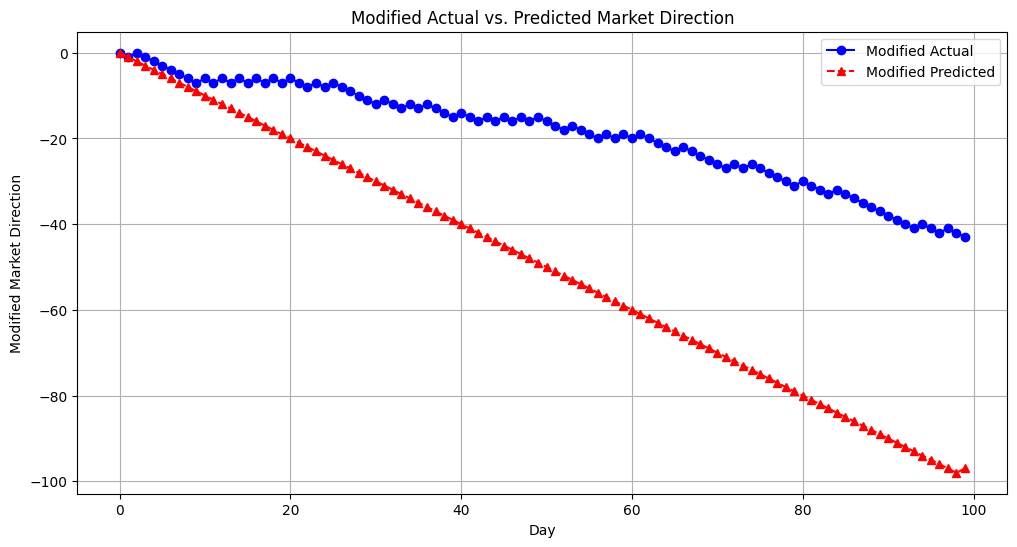

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with actual and predicted values
df = pd.DataFrame({'Actual': y_test_lstm, 'Predicted': pred_lstm.flatten()})

# Display the DataFrame
print(df)

# Create arrays to store modified values for actual and predicted market directions
modified_actual = []
modified_predicted = []

# Initialize variables to track the previous day's value
prev_actual = None
prev_predicted = None

# Iterate through actual and predicted market directions
for actual, predicted in zip(y_test_lstm, pred_lstm):
    # Calculate the modified value for actual market direction
    if prev_actual is None:
        modified_actual.append(0)
    else:
        modified_actual.append(modified_actual[-1] + (1 if actual > prev_actual else -1))
    prev_actual = actual
    
    # Calculate the modified value for predicted market direction
    if prev_predicted is None:
        modified_predicted.append(0)
    else:
        modified_predicted.append(modified_predicted[-1] + (1 if predicted > prev_predicted else -1))
    prev_predicted = predicted

# Create an array of days for the x-axis
days = range(len(y_test_lstm))

# Plot the modified values for actual and predicted market directions
plt.figure(figsize=(12, 6))
plt.plot(days, modified_actual, label='Modified Actual', color='blue', marker='o', linestyle='-')
plt.plot(days, modified_predicted, label='Modified Predicted', color='red', marker='^', linestyle='--')

plt.title('Modified Actual vs. Predicted Market Direction')
plt.xlabel('Day')
plt.ylabel('Modified Market Direction')
plt.legend()
plt.grid(True)
plt.show()
